# Laboratorio 8: *Puesta en producción de un modelo de ML*
## Javier Heredia - 21600 | Mario Cristales - 21631

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ydata_profiling import ProfileReport
import seaborn as sns
import math
from scipy.stats import zscore


C:\Users\PC\AppData\Local\Temp\ipykernel_6960\1182395767.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Parte 1: Selección de Modelos

### 1.1. Conjunto de datos

In [5]:
df = pd.read_csv('houses_to_rent_v2.csv')
print(df.shape)
df.head()

(10692, 13)


,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


### Proceso de selección de modelo

#### Exploración de Datos

In [ ]:
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'acept'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

El análisis de correlación muestra que varias variables presentan relaciones significativas entre sí. Por ejemplo, `area` está altamente correlacionada con `bathroom` y otras seis variables, indicando que el tamaño de la propiedad tiende a aumentar con el número de baños y otros factores relacionados. Otras variables, como `total (R$)`, también muestran alta correlación con hasta siete atributos, lo que sugiere una fuerte relación entre el costo total y factores como `hoa (R$)`, `rent amount (R$)`, y `property tax (R$)`.

El mapa de calor confirma estas observaciones al destacar las relaciones con tonalidades más oscuras para las correlaciones fuertes. Variables como `area`, `bathroom`, y `rooms` muestran alta correlación entre sí, lo que refleja una tendencia lógica en la que propiedades más grandes suelen tener más habitaciones y baños. Por otro lado, algunas variables presentan correlaciones más débiles, indicadas por colores más cercanos al blanco, lo que indica relaciones menos significativas entre estos atributos.

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as

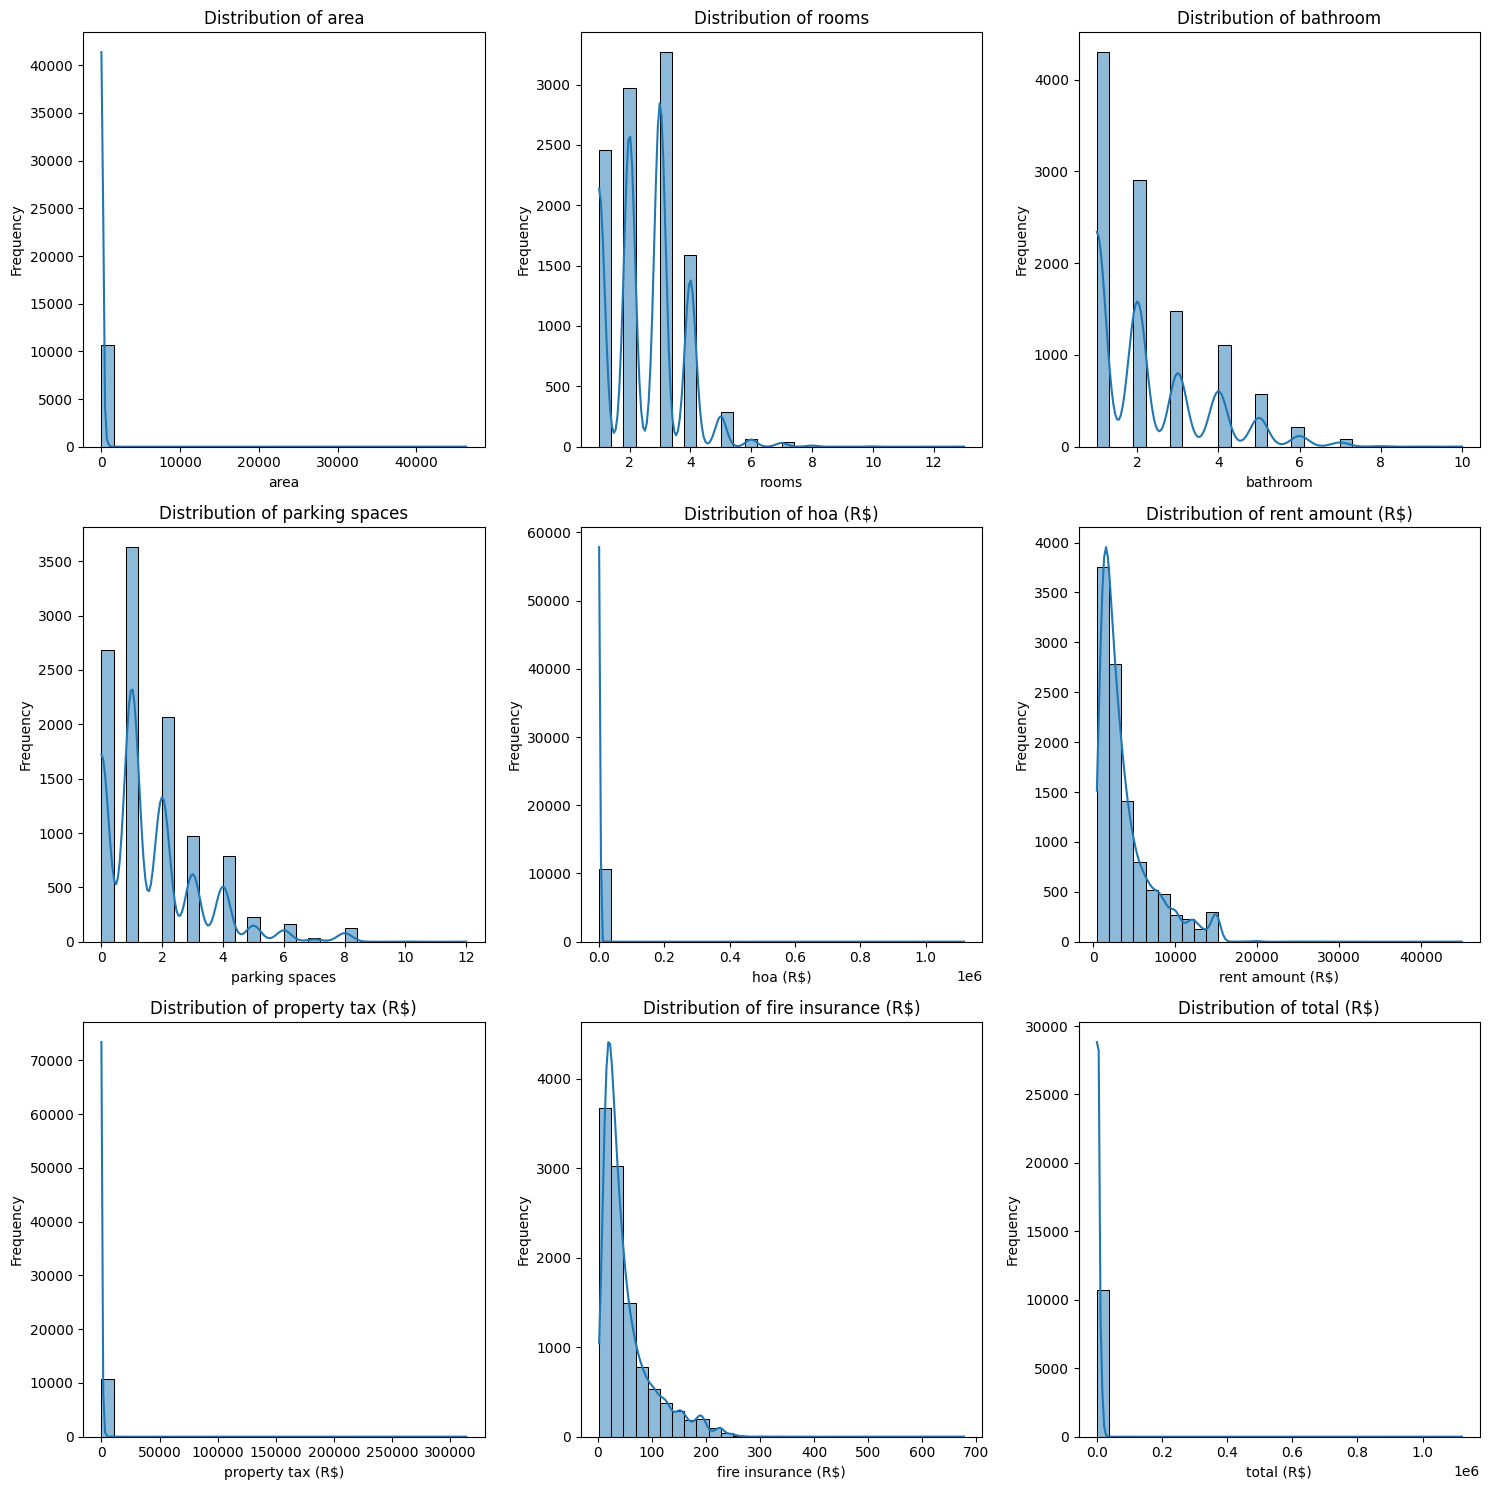

In [6]:
num_columns = df.select_dtypes(include=['float64', 'int64']).columns

num_vars = len(num_columns)
cols = 3
rows = math.ceil(num_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

for i, column in enumerate(num_columns):
    row = i // cols
    col = i % cols
    sns.histplot(df[column], kde=True, ax=axes[row, col], bins=30)
    axes[row, col].set_title(f'Distribution of {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')

for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

### Preprocesamiento de Datos

In [7]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].apply(lambda x: 0 if '-' in str(x) else x)

df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020


In [8]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100


missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_data = missing_data[missing_data['Missing Values'] > 0]
missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

In [10]:
iqr_outliers = pd.DataFrame()
removed_rows = []

multiplicador = 3

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplicador * IQR
    upper_bound = Q3 + multiplicador * IQR
    outlier_indices = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
    iqr_outliers[column] = df.loc[outlier_indices, column]
    
    for index in outlier_indices:
        removed_rows.append((index, column, df.at[index, column]))

iqr_outliers.dropna(how='all', inplace=True)

contador = 0

for row in removed_rows:
    contador += 1

df_clean = df.drop(iqr_outliers.index)

print(f"Se eliminaron {contador} filas con outliers")


Se eliminaron 1180 filas con outliers


In [11]:
#hot encoding
df_clean = pd.get_dummies(df_clean, columns=['city', 'animal', 'furniture'])
df_clean.head()

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),city_Belo Horizonte,city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo,animal_acept,animal_not acept,furniture_furnished,furniture_not furnished
0,70,2,1,1,7,2065,3300,211,42,5618,False,False,False,False,True,True,False,True,False
1,320,4,4,0,20,1200,4960,1750,63,7973,False,False,False,False,True,True,False,False,True
2,80,1,1,1,6,1000,2800,0,41,3841,False,False,True,False,False,True,False,False,True
3,51,2,1,0,2,270,1112,22,17,1421,False,False,True,False,False,True,False,False,True
4,25,1,1,0,1,0,800,25,11,836,False,False,False,False,True,False,True,False,True


No se requiere de normalizacion para este conjunto de datos, en este punto del preprocesamiento. 

### Entrenamiento y selección de modelos
Se utilizaron los recomendados

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

df_comparison = df_clean.copy()

X = df_comparison.drop(columns=['total (R$)'])
y = df_comparison['total (R$)']

# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    accuracy = model.score(X_test, y_test)
    
    results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'accuracy': accuracy
    }

# Mostrar los resultados
print("Comparación de Modelos:")
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"MAE: {metrics['MAE']}")
    print(f"R²: {metrics['R²']}")
    print(f"Accuracy: {metrics['accuracy']:.2f}")

best_model = min(results, key=lambda k: (results[k]['RMSE'], results[k]['MAE'], -results[k]['R²']))

print(f"Best model: {best_model}")

Comparación de Modelos:
Model: Linear Regression
RMSE: 2.7442416196648964
MAE: 0.5788864661608687
R²: 0.9999999876337932
Accuracy: 1.00
Model: Random Forest
RMSE: 8487.945961514404
MAE: 260.73108416547785
R²: 0.8816966544930449
Accuracy: 0.88
Model: Gradient Boosting
RMSE: 163.518742127223
MAE: 112.2675434856402
R²: 0.9999560936950359
Accuracy: 1.00
Best model: Linear Regression


In [19]:
import joblib
best_model_object = models[best_model]

joblib.dump(best_model_object, 'best_model.joblib')

model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')

['model_columns.pkl']

### Interpretación de resultados

En la evaluación comparativa de los tres modelos entrenados se observan los siguientes resultados:

Regresión Lineal:

- RMSE: 1.11
- MAE: 0.55
- R²: 0.9999

Este modelo destaca con el menor error cuadrático medio (RMSE) y error absoluto medio (MAE), lo que sugiere que sus predicciones están muy cercanas a los valores reales. El R², prácticamente en 1, indica que el modelo captura casi toda la variabilidad de los datos.

Random Forest:

- RMSE: 2217.32
- MAE: 144.05
- R²: 0.89

A pesar de ser un modelo potente para capturar relaciones no lineales, en este caso, Random Forest tiene un RMSE y MAE significativamente más altos que la regresión lineal, y un R² más bajo. Esto sugiere que no se ajusta tan bien a los datos en comparación.

Gradient Boosting:

- RMSE: 1049.67
- MAE: 157.12
- R²: 0.976

Gradient Boosting muestra un rendimiento intermedio. Si bien tiene un R² elevado, indicando que explica gran parte de la variabilidad, sus valores de RMSE y MAE son bastante más altos que los de la regresión lineal, lo que revela que no es tan preciso en sus predicciones.

<br>

La Regresión Lineal resulta ser el modelo superior, con los errores más bajos y un R² casi perfecto, lo que la convierte en la opción más adecuada.

Ventajas: Su capacidad para capturar relaciones lineales de manera precisa y eficiente.
Limitaciones de los Otros Modelos: A pesar de las ventajas que ofrecen Random Forest y Gradient Boosting al manejar relaciones complejas, en este caso no proporcionan mejoras significativas, ya que presentan errores más elevados.